# Pooling and Blending

In [630]:
# Import Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

## Bibliographic Notes

The pooling and blending is a large scale and high value problem in the process and refining industries. The prototypical examples are the pooling and blending crude oils to meet the feed stock constraints of refineries, and the pooling of refinery products for pipeline delivery to distribution facilities where products are blended for retail sale.

Haverly (1978) is a commonly cited small benchmark problem for the pooling and blending of sulfurous fuels. 

> Haverly, C. A. (1978). Studies of the behavior of recursion for the pooling problem. Acm sigmap bulletin, (25), 19-28. https://dl.acm.org/doi/pdf/10.1145/1111237.1111238

There is an extensive literature on pooling and blending. The following encyclopedia entry explains the history of the pooling problem, how it leads to multiple local minima and other pathological behaviors, and approaches to finding practical solutions.

> Visweswaran, V. (2009). MINLP: Applications in Blending and Pooling Problems. https://link.springer.com/referenceworkentry/10.1007/978-0-387-74759-0_375

Recent research overviews include


> Misener, R., & Floudas, C. A. (2009). Advances for the pooling problem: Modeling, global optimization, and computational studies. Applied and Computational Mathematics, 8(1), 3-22. https://www.researchgate.net/profile/Ruth-Misener/publication/242290955_Advances_for_the_pooling_problem_Modeling_global_optimization_and_computational_studies_Survey/links/0046352e7d1dfeb40f000000/Advances-for-the-pooling-problem-Modeling-global-optimization-and-computational-studies-Survey.pdf

> Gupte, A., Ahmed, S., Dey, S. S., & Cheon, M. S. (2013). Pooling problems: relaxations and discretizations. School of Industrial and Systems Engineering, Georgia Institute of Technology, Atlanta, GA. and ExxonMobil Research and Engineering Company, Annandale, NJ. http://www.optimization-online.org/DB_FILE/2012/10/3658.pdf

The current state-of-the-art appears to be a formulation of the pooling problem is a mixed-integer quadratically-constrained quadratic optimization on a given network.

> Ceccon, F., & Misener, R. (2022). Solving the pooling problem at scale with extensible solver GALINI. Computers & Chemical Engineering, 107660. https://arxiv.org/pdf/2105.01687.pdf

Applications for pooling and blending are probably underappreciated. In particular, what role might pooling and blending problems have in projects like the World Food Programme (WFP)?

## Example: Pooling Milk for Wholesale Blending and Distribution

A bulk distributor supplies several customers with deliveries of raw milk purchased from local farms. The deliveries may be blended to meet the minimum required milk fat content specified by each customer.

The distributor has found lower cost sources of raw milk from several farms located a long distance away. The distant farms produce grades of milk that may be blended with local sources. The distributor, however, has just one truck available to transport raw milk from the distant farms to the blending facility. Therefore any milk purchased from the distant farms would be pooled for transport to the blending station. 

The situation is illustrated in the following diagram where the arrows show the flow and blending of milk supplies.

![](milk-pooling.dio.png)


What should the farmer do?

* Option 1. Do nothing, continue with business as usual.

* Option 2. Buy a second truck to bring raw milk from the remote farms without pooling.

* Option 3. Pool raw milk from the remote farms for transport to the blending facility.


In [616]:
import pandas as pd

customers = pd.DataFrame({
    "Customer A": {"fat": 0.0445, "price": 52.0, "demand": 6000.0},
    "Customer B": {"fat": 0.030, "price": 48.0, "demand": 2500.0}
}).T

suppliers = pd.DataFrame({
    "Farm A": {"fat": 0.045, "cost": 45.0, "location": "local"},
    "Farm B": {"fat": 0.030, "cost": 42.0, "location": "local"},
    "Farm C": {"fat": 0.033, "cost": 37.0, "location": "remote"},
    "Farm D": {"fat": 0.050, "cost": 45.0, "location": "remote"}},
    ).T

local_suppliers = suppliers[suppliers["location"]=="local"]
remote_suppliers = suppliers[suppliers["location"]=="remote"]

print("\nCustomers")
display(customers)

print("\nLocal Suppliers")
display(local_suppliers)

print("\nRemote Suppliers")
display(remote_suppliers)



Customers


,fat,price,demand
Customer A,0.0445,52.0,6000.0
Customer B,0.0300,48.0,2500.0



Local Suppliers


,fat,cost,location
Farm A,0.045,45.0,local
Farm B,0.03,42.0,local



Remote Suppliers


,fat,cost,location
Farm C,0.033,37.0,remote
Farm D,0.05,45.0,remote


## Option 1. Business as usual

Business as usual for the milk distributor is to blend supplies from the two local farms to meet customer requirements. Let $L$ designate the set of local suppliers, and let $C$ designate the set of customers. The decision variable $x_{l, c}$ is the amount of milk from local supplier $l\in L$ mixed into the blend for customer $c\in C$.

The distributor's objectives is to maximize profit

$$
\begin{align*}
\text{Profit} & = \sum_{(l,c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l) x_{l,c}
\end{align*}
$$ 

where the notation $(l,c)\ \in\ L\times C$ indicates a summation over the cross-product of two sets. A useful interpretation is that $(l,c)\ \in\ L\times C$ describes all ways of delivering milk from $l$ to $c$. Each term $(\text{price}_c - \text{cost}_l)$ is then the profit earned by delivering one unit of milk from $l\in L$ to $c\in C$.

The amount of milk delivered to each customer $c\in C$ can not exceed customer demand.

$$
\begin{align*}
\sum_{l\in L} x_{l, c} & \leq \text{demand}_{c} & \forall c\in C
\end{align*}
$$

The milk blend delivered to each customer $c\in C$ must meet the minimum product quality requirement for milk fat. Assuming linear blending, the model becomes

$$
\begin{align*}
\sum_{(l,c)\ \in\ L \times C} \text{conc}_{l} x_{l,c} & \geq \text{conc}_{c} \sum_{l\in L} x_{l, c} & \forall c \in C
\end{align*}
$$

This is a standard linear blending problem.

In [617]:
import pyomo.environ as pyo

q = "fat"

m = pyo.ConcreteModel()

# define sources and customers
m.L = pyo.Set(initialize=local_suppliers.index)
m.C = pyo.Set(initialize=customers.index)
m.L2C = m.L * m.C

# set of quality components
m.Q = pyo.Set(initialize=["fat"])

# define local -> customer flowrates
m.x = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)

@m.Objective(sense=pyo.maximize)
def profit(m):
    return sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L2C)

@m.Constraint(m.C)
def demand(m, c):
    return sum(m.x[l, c] for l in m.L) <= customers.loc[c, "demand"]

@m.Constraint(m.C)
def quality(m, c):
    return sum(m.x[l, c] * suppliers.loc[l, q] for l in m.L) >= sum(m.x[l, c] for l in m.L) * customers.loc[c, q]

pyo.SolverFactory('cbc').solve(m)

print(f"\nprofit = {m.profit():0.2f}\n")

X = pd.DataFrame([[l, c, round(m.x[l, c](), 1)] for l, c in m.L2C], columns = ["supplier", "customer", "blend"])
X = X.pivot_table(index="customer", columns="supplier")

X["fat"]  = sum(X.loc[:,('blend',l)] * suppliers.loc[l, "fat"] for l in m.L)/X.sum(axis=1)
X["Total"] = X.sum(axis=1)
display(X)



profit = 57600.00



blend             fat      Total
supplier    Farm A  Farm B                   
customer                                     
Customer A  5800.0   200.0  0.0445  6000.0445
Customer B     0.0  2500.0  0.0300  2500.0300

## Option 2. Buy an additional truck

The current profit earned is 58,200 using only local suppliers. Before considering pooling, however, the distributor may wish to know the maximum profit potential that could be earned if the remote suppliers could be blended as if they were local suppliers. This would require acquiring and operating a separate transport for each remote supplier, so it is worth knowing if the additional profit earned would justify the additional expense.

The model used above applies by extending the set of suppliers to include both local and remote farms. The required changes are noted in the cell below.

In [618]:
import pyomo.environ as pyo

q = "fat"

m = pyo.ConcreteModel()

# define sources and customers
m.R = pyo.Set(initialize=remote_suppliers.index)       # <== set of remote suppliers
m.L = m.R | pyo.Set(initialize=local_suppliers.index)  # <== treat remote suppliers same a local suppliers
m.C = pyo.Set(initialize=customers.index)
m.L2C = m.L * m.C

# set of quality components
m.Q = pyo.Set(initialize=["fat"])

# define local -> customer flowrates
m.x = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)

@m.Objective(sense=pyo.maximize)
def profit(m):
    return sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L2C)

@m.Constraint(m.C)
def demand(m, c):
    return sum(m.x[l, c] for l in m.L) <= customers.loc[c, "demand"]

@m.Constraint(m.C)
def quality(m, c):
    return sum(m.x[l, c] * suppliers.loc[l, q] for l in m.L) >= sum(m.x[l, c] for l in m.L) * customers.loc[c, q]

pyo.SolverFactory('cbc').solve(m)

print(f"\nprofit = {m.profit():0.2f}\n")

X = pd.DataFrame([[l, c, round(m.x[l, c](), 1)] for l, c in m.L2C], columns = ["supplier", "customer", "blend"])
X = X.pivot_table(index="customer", columns="supplier")

X["fat"]  = sum(X.loc[:,('blend',l)] * suppliers.loc[l, "fat"] for l in m.L)/X.sum(axis=1)
X["Total"] = X.sum(axis=1)
display(X)



profit = 85029.41



blend                            fat      Total
supplier   Farm A Farm B  Farm C  Farm D                   
customer                                                   
Customer A    0.0    0.0  1941.2  4058.8  0.0445  6000.0445
Customer B    0.0    0.0  2500.0     0.0  0.0330  2500.0330

The calculations show that purchasing raw milk from the remote farms can significantly increases profits. The blending plan, however, requires transporting 4,618 units of raw milk from farms C, and additional 3,882 units of raw milk from farm C.  The plan does not allow pooling these sources prior to transport, otherwise they would somehow need to be "unblended" to meet the minimum quality requirement for customer A.

## Option 3. Pool delivery from remote farms

Analysis of the first two options shows there is significant additional profit to be earned by purchasing raw milk from the remote farms. But the option requires acquiring and operating an additional truck to keep the materials separate for later blending. Blending at the remote location is also not an option because that plan, too, would require separate transport. 

The natural question is whether the one existing truck could transport a pool of raw milk from remote farms C and D that could be blended with raw milk from local farms A and B to meet customer requirements. The profit potential may be reduced due to pooling, but it may still be a better option than adding additional operating expense.

There are a number of formulations of this problem. This analysis will use a version of the "p-parameterization" where composition of the pool is a decision variable. Here that variable will be called $f$.

Other decision variables are also needed. Decision variables $y_c$ refer to the amount of the pool used in the blend delivered to customer $c\in C$. Variables $z_r$ ar the amount of raw milk purchased from remote farm $r$ and included in the pool.

Again, the objective is to maximize profit

$$
\begin{align*}
\text{Profit} & = \sum_{(l,c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l) x_{l,c}
+ \sum_{c\in C} \text{price}_c y_{c} - \sum_{r\in R} \text{cost}_r z_{r}
\end{align*}
$$

where additional terms are included for the cost of raw milk included in the pool, and customer revenue earned from use of the pool. 

The product delivered to each customer can not exceed customer demand.

$$
\begin{align*}
\sum_{l\in L} x_{l, c} + y_{c} & \leq \text{demand}_{c} & \forall c\in C
\end{align*}
$$

A  incoming and outgoing flows to the pool must balance.

$$
\begin{align*}
\sum_{r\in R}z_{r} & = \sum_{c\in C} y_{c} \\
\end{align*}
$$

The milk fat composition of the pool, $f$, is given by averaging contributions from the remote farms.

$$
\begin{align*}
\sum_{r\in R}\text{conc}_{r} z_{r}  & = \underbrace{f \sum_{c\in C} y_{c}}_{\text{bilinear}}
\end{align*}
$$

Finally, the minimum milk fat required by each customer $c\in C$ satisfies a blending constraint.

$$
\begin{align*}
\underbrace{f y_{c}}_{\text{bilinear}}  + \sum_{(l,c)\ \in\ L \times C} x_{l,c} \text{conc}_{l} 
& \geq \text{conc}_{c} (\sum_{l\in L} x_{l, c} + y_{c})
& \forall c \in C
\end{align*}
$$

The last two constraints include bilinear terms from the project of decision variable $f$ with decision variables $y_c$ for all $c\in C$. 

Text(0, 0.5, 'Profit')

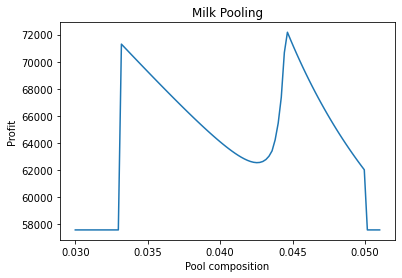

In [623]:
import pyomo.environ as pyo

def p_milk(f=0, q="fat"):
    
    m = pyo.ConcreteModel()

    # define sources 
    m.L = pyo.Set(initialize=local_suppliers.index)
    m.R = pyo.Set(initialize=remote_suppliers.index)

    # define customers
    m.C = pyo.Set(initialize=customers.index)

    # define flowrates
    m.x = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)
    m.y = pyo.Var(m.C, domain=pyo.NonNegativeReals)
    m.z = pyo.Var(m.R, domain=pyo.NonNegativeReals)

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return + sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
               + sum(m.y[c]*customers.loc[c, "price"] for c in m.C) \
               - sum(m.z[r]*suppliers.loc[r, "cost"] for r in m.R)

    @m.Constraint(m.C)
    def customer_demand(m, c):
        return sum(m.x[l, c] for l in m.L) + m.y[c] <= customers.loc[c, "demand"]
    
    @m.Constraint()
    def pool_balance(m,):
        return sum(m.z[r] for r in m.R) == sum(m.y[c] for c in m.C)
    
    @m.Constraint()
    def pool_quality(m):
        return sum(suppliers.loc[r, q] * m.z[r] for r in m.R) == f * sum(m.y[c] for c in m.C)
    
    @m.Constraint(m.C)
    def customer_quality(m, c):
        return f * m.y[c] + sum(suppliers.loc[l, q] * m.x[l, c] for l in m.L) \
                 >= customers.loc[c, q] * (sum(m.x[l, c] for l in m.L) + m.y[c])

    pyo.SolverFactory('cbc').solve(m)
    
    return m

f = np.linspace(0.03, 0.051, 100)
p = [p_milk(f).profit() for f in f]

plt.plot(f, p)
plt.title("Milk Pooling")
plt.xlabel("Pool composition")
plt.ylabel("Profit")

In [629]:
m = p_milk(0.045)
m.profit()
m.z.display()

z : Size=2, Index=R
    Key    : Lower : Value     : Upper : Fixed : Stale : Domain
    Farm C :     0 : 1705.8824 :  None : False : False : NonNegativeReals
    Farm D :     0 : 4094.1176 :  None : False : False : NonNegativeReals


## Exercise

1. Rather than scan values of $f$ to look for an optimum, revise the Pyomo model to find the optimum value. This will be a nonlinear optimization, and a challenging one at that.  Try using 'gurobi_direct' and 'ipopt' solvers to find a solution. Did you find a solver that could solve this nonlinear problem?

2. The above analysis assumed unlimited transport. The truck turns out to have a limit of 4,000 units of milk. Write the mathematical constraint necessary to introduce that limit into the model. Then add that constraint to the Pyomo model and discuss the impact on profit.